In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

import os
import numpy as np
import pandas as pd
import geopandas as gpd

FEATURES_PATH = "../data/audio_features_processed.csv"
CHARTS_PATH = "../data/charts_processed.csv"
OUTPUT_PATH = '../data/'
CHARTS_V2_PATH = "../data/charts_processed_v2.csv"
FIGURES_PATH = "../figures/"

from source.utils.visualization import plot_similarity_matrix_from_file, plot_cluster_map, plot_world_map, plot_lines_between_countries
from source.utils.regions import k_means_clustering

In [2]:
# show which files that can be used for plotting in the data path
print("Available files for plotting:")
for file in os.listdir(OUTPUT_PATH):
    if file.endswith(".npy"):
        print(file)

Available files for plotting:
region_influence_dict_08_02.npy


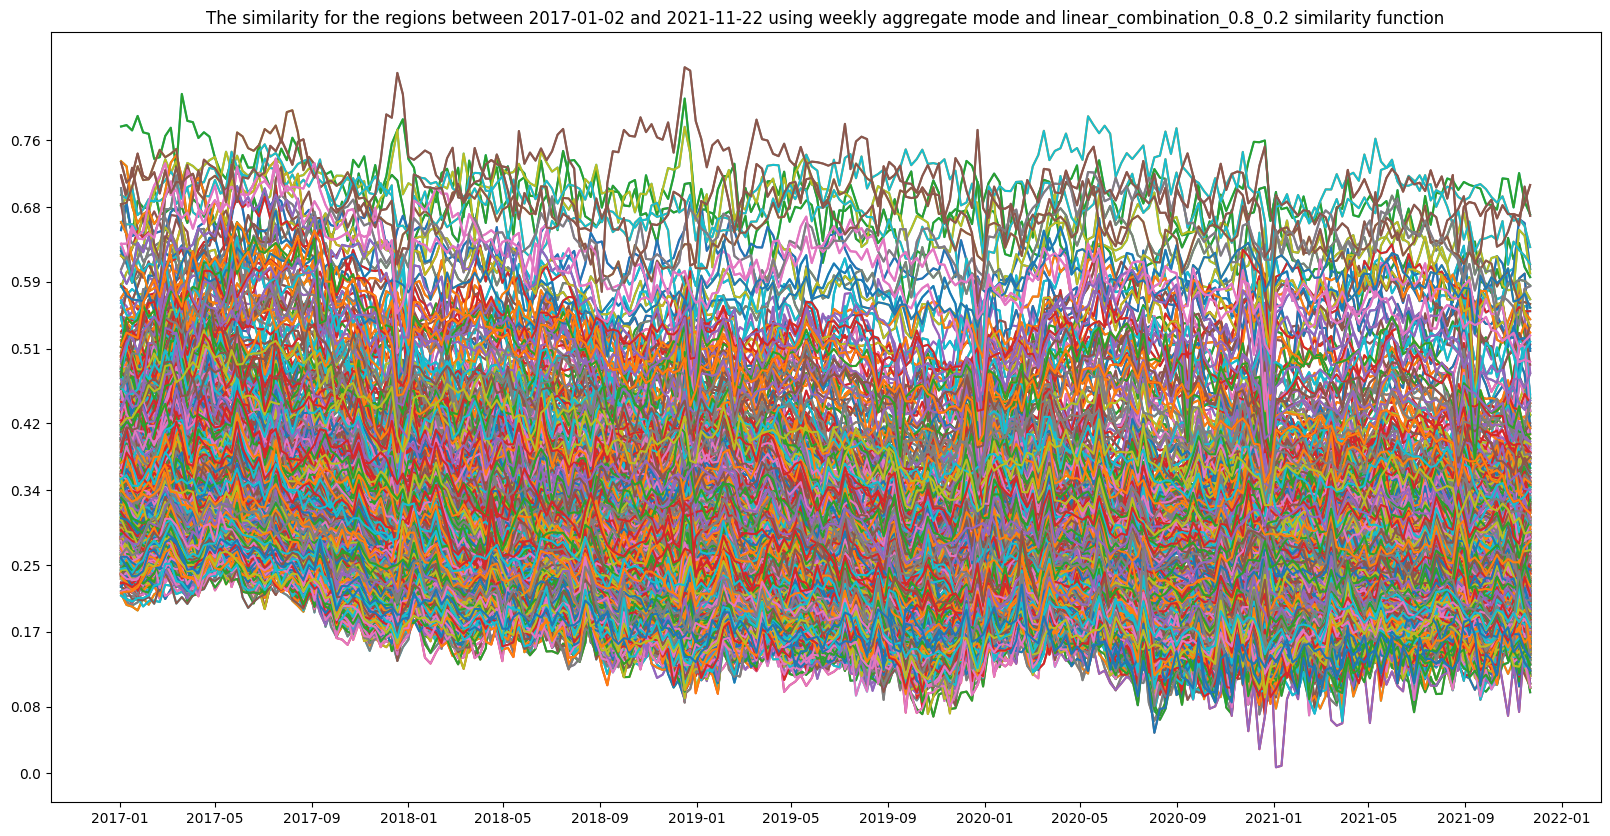

In [3]:
plot_similarity_matrix_from_file(OUTPUT_PATH + "region_influence_dict_08_02.npy", FIGURES_PATH)

In [4]:
def unpack(file):
    return file['similarity_matrix'], file['region_array'], file['dates'], file['info_dict'], file['region_influence_df']

# unpack the file
similarity_matrix, region_array, dates, info_dict, region_influence_df = unpack(np.load(OUTPUT_PATH + "region_influence_dict_08_02.npy", allow_pickle=True).item())

In [5]:
# rename the column 'region' to 'name' so that it can be merged with the world map new dataframe
region_influence_df = region_influence_df.rename(columns={'region': 'name'})
region_influence_df

,name,influence
0,Australia,12.227910
1,Belgium,12.108693
2,New Zealand,11.991751
3,Switzerland,11.919048
4,Ireland,11.907165
5,Canada,11.825925
6,Costa Rica,11.551055
7,Portugal,11.509785
8,United Kingdom,11.489726
9,Singapore,11.348424


In [6]:
# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

In [7]:
region_influence_df_copy = region_influence_df.copy()

# singapore is not in the world map, so we change it to Malaysia
# The name of the country of Czech Republic is Czechia in the world map
# The name of the country of United States is United States of America in the world map
# Honk Kong is not in the world map, so we change it to China for visualization purposes
region_influence_df.loc[region_influence_df['name'] == 'Singapore', 'name'] = 'Malaysia'
region_influence_df.loc[region_influence_df['name'] == 'Czech Republic', 'name'] = 'Czechia'
region_influence_df.loc[region_influence_df['name'] == 'United States', 'name'] = 'United States of America'
region_influence_df.loc[region_influence_df['name'] == 'Hong Kong', 'name'] = 'China'

# change the dtype of region_array to untlimited string
region_array = region_array.astype('<U32')

region_array[region_array == 'United States'] = 'United States of America'
region_array[region_array == 'Hong Kong'] = 'China'
region_array[region_array == 'Czech Republic'] = 'Czechia'
region_array[region_array == 'Singapore'] = 'Malaysia'

print(region_array)

# Merge the world map with the region_influence_dict but keep all of the countries in the world map and assign 0 to the countries that are not in region_influence_dict
world = world.merge(region_influence_df, on='name', how='left')

# check if all values of region_influence_dict are in world
for country in region_influence_df['name']:
    if country not in world['name'].values:
        print(country)

['Brazil' 'Argentina' 'United States of America' 'Austria' 'Australia'
 'Canada' 'United Kingdom' 'Switzerland' 'France' 'Philippines' 'Malaysia'
 'Belgium' 'Ireland' 'Indonesia' 'China' 'Malaysia' 'Denmark' 'Sweden'
 'New Zealand' 'Ecuador' 'Colombia' 'Costa Rica' 'Italy' 'Spain' 'Mexico'
 'Finland' 'Turkey' 'Taiwan' 'Chile' 'Norway' 'Peru' 'Poland'
 'Netherlands' 'Portugal' 'Germany' 'Czechia' 'Japan' 'Guatemala'
 'Uruguay']


In [8]:
print(world.to_crs('+proj=cea')['geometry'].centroid.to_crs(world.crs).values[0])

POINT (163.77640725005324 -17.31277520899394)


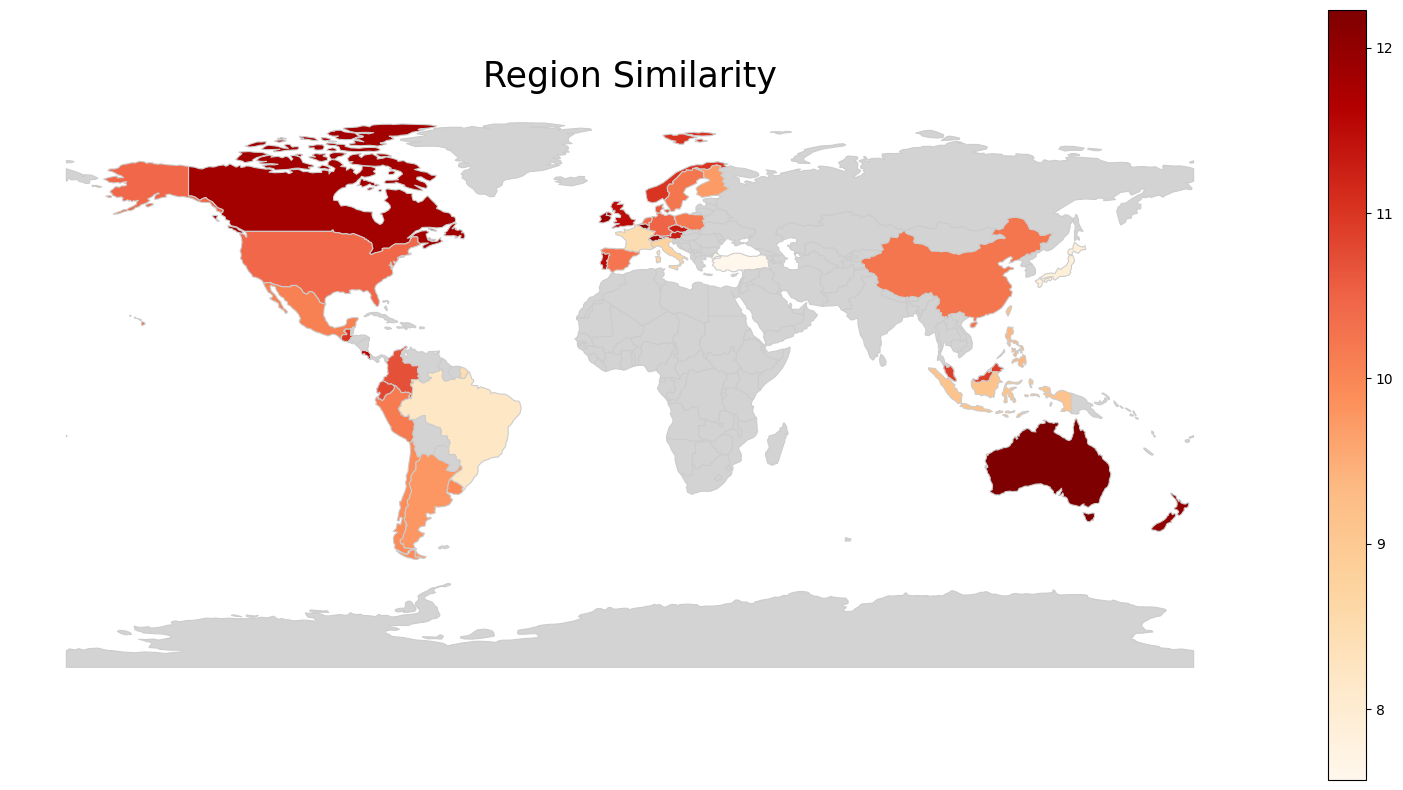

In [9]:
plot_world_map(world, 'influence', 'Region Similarity', FIGURES_PATH)

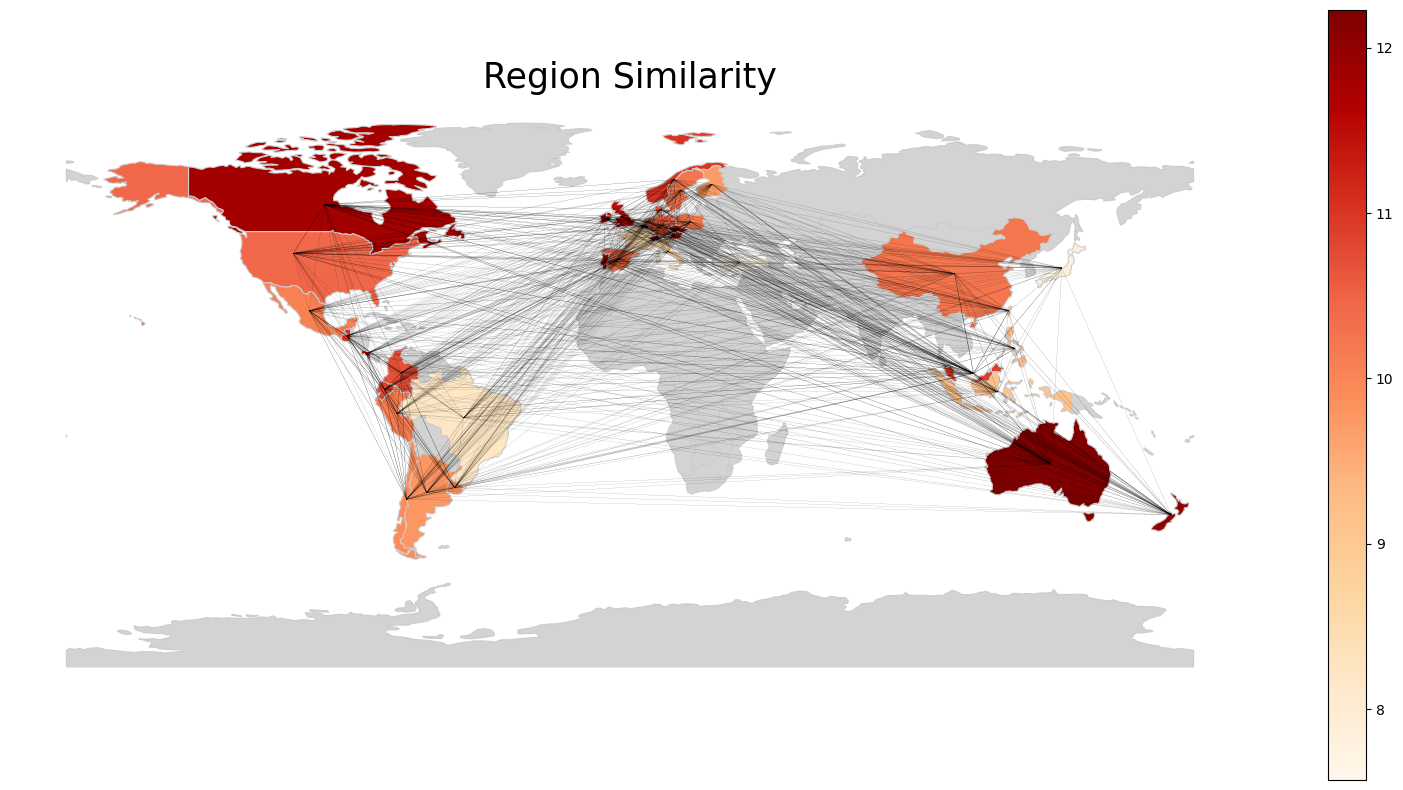

In [10]:
plot_lines_between_countries(world, 'influence', similarity_matrix, title='Region Similarity', region_array=region_array, figures_path=FIGURES_PATH)

Cluster 2: 13
Cluster 1: 9
Cluster 0: 16
Cluster 3: 1


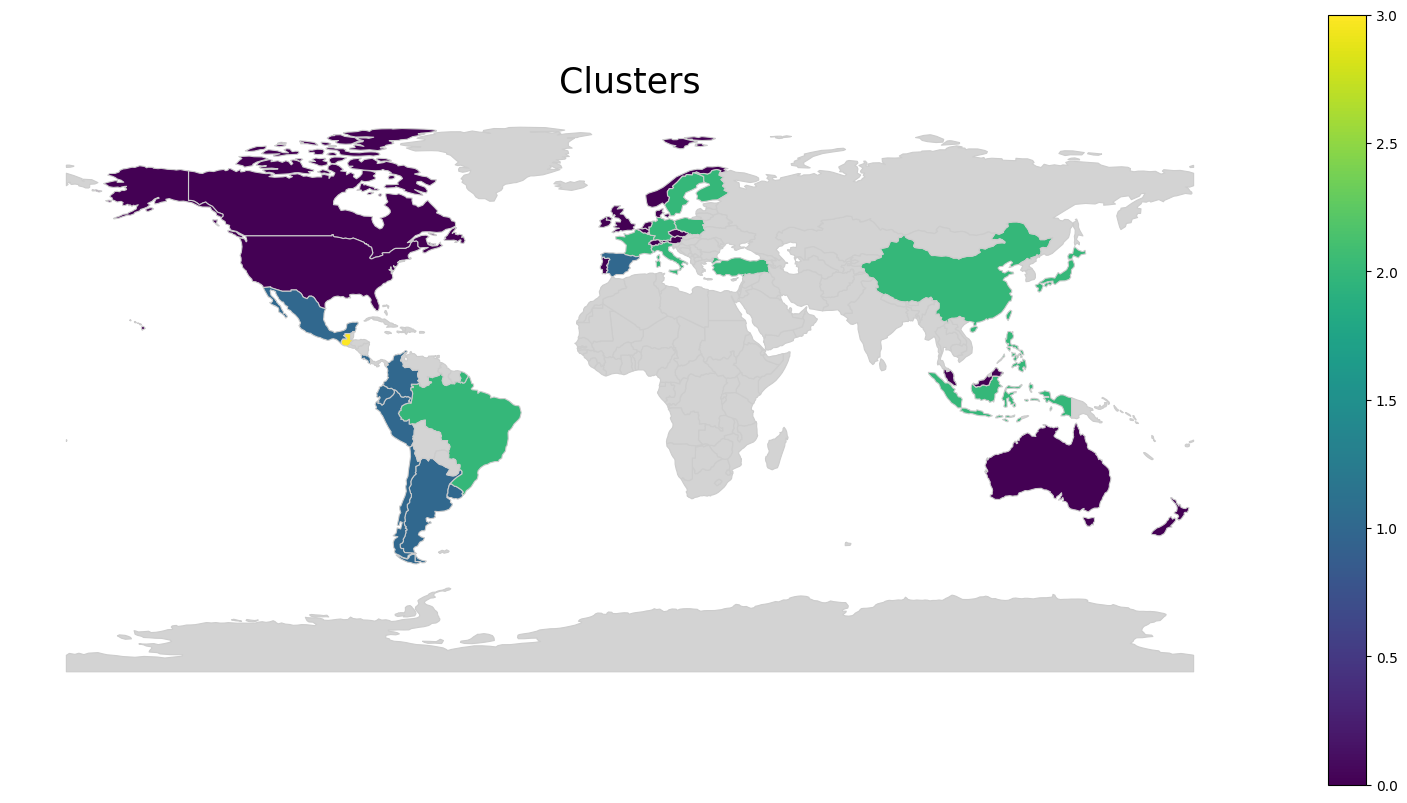

In [11]:
cluster_dict = k_means_clustering(similarity_matrix, region_array, num_clusters=4)
world['cluster'] = world['name'].map(cluster_dict)
plot_cluster_map(world, 'cluster', 'Clusters', FIGURES_PATH)